In [1]:
import scispacy
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import zipfile
import os
import xmltodict
import json
import zlib
import resource
import sys
import regex as re
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook as tqdm
import nltk.data
from multiprocessing import Pool
#nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

##### Filetr by aticle type LT and AR

In [3]:
article_df = pd.read_hdf('data/nature/preprocessed/article_df.hdf')

In [3]:
article_df

,ArticleID,DOI,Issue,Volume,PageEnd,PageStart,PubYear,SortDate,Title,Type,Journal
0,048485a0,10.1038/048485a0,1247.0,48.0,508.0,485.0,1893,1893-09-21,The British Association,ed,Nature
1,048508a0,10.1038/048508a0,1247.0,48.0,509.0,508.0,1893,1893-09-21,The Thieving of Assyrian Antiquities\r\n,lt,Nature
2,048509a0,10.1038/048509a0,1247.0,48.0,509.0,509.0,1893,1893-09-21,Bishop's Ring\r\n,lt,Nature
3,048509b0,10.1038/048509b0,1247.0,48.0,509.0,509.0,1893,1893-09-21,Spring and Autumn of 1893\r\n,lt,Nature
4,048509c0,10.1038/048509c0,1247.0,48.0,512.0,509.0,1893,1893-09-21,Notes,misc,Nature
...,...,...,...,...,...,...,...,...,...,...,...
395498,149145b0,10.1038/149145b0,3770.0,149.0,146.0,145.0,1942,1942-01-31,NATIVE SUBSISTENCE ON THE AMERICAN CENTRAL PLAINS,nw,Nature
395499,149146a0,10.1038/149146a0,3770.0,149.0,146.0,146.0,1942,1942-01-31,EARTHQUAKE ORIGINS IN THE NEW ZEALAND REGION,nw,Nature
395500,149146b0,10.1038/149146b0,3770.0,149.0,146.0,146.0,1942,1942-01-31,FORTHCOMING EVENTS,misc,Nature
395501,149146c0,10.1038/149146c0,3770.0,149.0,146.0,146.0,1942,1942-01-31,APPOINTMENTS VACANT,misc,Nature


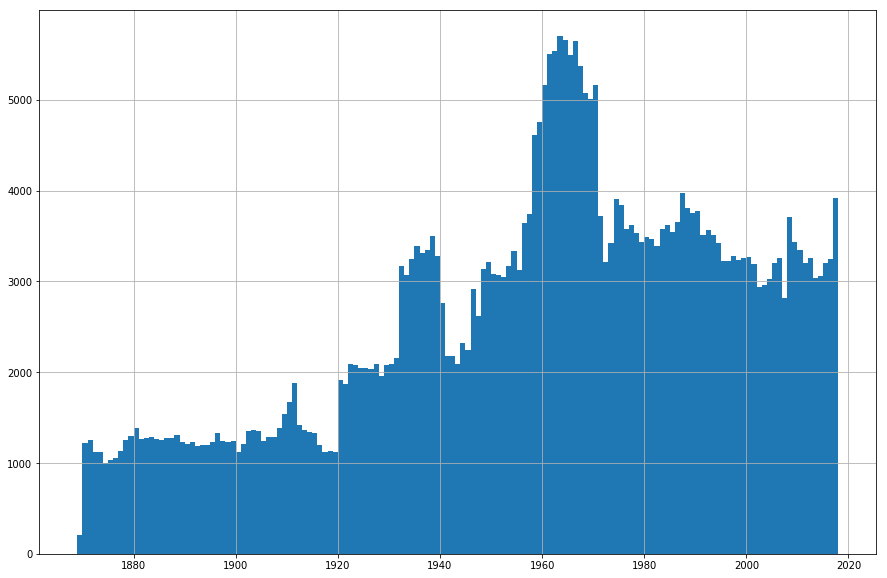

In [4]:
article_df['PubYear'].hist(bins = (article_df['PubYear'].max() - article_df['PubYear'].min()), figsize = (15, 10))

In [5]:
x = list(article_df[['ArticleID','PubYear']].groupby('PubYear').count()['ArticleID'])

In [57]:
w = np.fft.fft(x)
freqs = np.fft.fftfreq(len(w))

In [58]:
for coef,freq in zip(w,freqs):
    if coef:
        print('{c:>6} * exp(2 pi i t * {f})'.format(c=coef,f=freq))

(395503+0j) * exp(2 pi i t * 0.0)
(-47741.08173227605+108296.56565066085j) * exp(2 pi i t * 0.006666666666666667)
(-2916.647505104697-4446.201373113057j) * exp(2 pi i t * 0.013333333333333334)
(10539.743735805234+19397.577300762736j) * exp(2 pi i t * 0.02)
(-25020.935120043745+20768.783330945193j) * exp(2 pi i t * 0.02666666666666667)
(12143.577118135774-11115.604172927051j) * exp(2 pi i t * 0.03333333333333333)
(-7739.549818821184+29193.817441610612j) * exp(2 pi i t * 0.04)
(-11897.168711957263+2992.0775355719984j) * exp(2 pi i t * 0.04666666666666667)
(-2124.4129891429643+1883.9264314710495j) * exp(2 pi i t * 0.05333333333333334)
(-2058.8926500048374+8760.953164608516j) * exp(2 pi i t * 0.060000000000000005)
(-12443.556051734498-732.4449024497588j) * exp(2 pi i t * 0.06666666666666667)
(7775.474178371135+8722.553310698155j) * exp(2 pi i t * 0.07333333333333333)
(-10919.90605381349-3971.8651346329198j) * exp(2 pi i t * 0.08)
(-2641.354099406623+6462.622597416276j) * exp(2 pi i t * 0.0

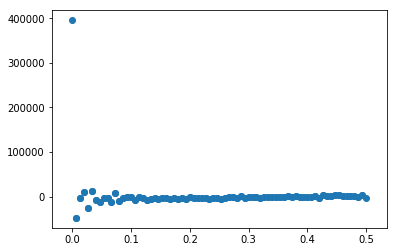

In [63]:
plt.scatter(abs(freqs), w)

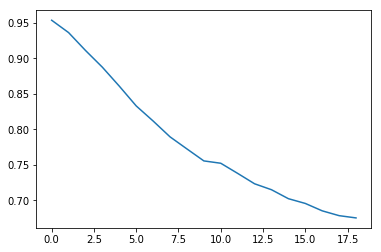

In [125]:
def autocorr(x, max_lag, steps):
    
    results = []
    
    for i in range(1, max_lag, steps):
        
        x_hat = np.append(np.zeros(i), x[:len(x)-i])
        results.append(np.corrcoef(x, x_hat)[1][0])
        
    return results

plt.plot(autocorr(x, 20, 1))

In [135]:
article_df.loc[0]

ArticleID                   048485a0
DOI                 10.1038/048485a0
Issue                           1247
Volume                            48
PageEnd                          508
PageStart                        485
PubYear                         1893
SortDate                  1893-09-21
Title        The British Association
Type                              ed
Journal                       Nature
Name: 0, dtype: object

In [145]:
with open('data/nature/preprocessed/abstract_df.pickle', 'rb') as f:
        abstract_df = pickle.load(f)

In [149]:
abstract_df

,ArticleID,Abstract
0,048485a0,THE Nottingham meeting of the British Associat...
1,048508a0,I HAD hoped that the British Museum slander ca...
2,048509a0,BISHOP'S RING still continues very conspicuous...
3,048509b0,As the peculiarities of this season are receiv...
4,048509c0,"MR. W. SAVILLE-KENT, at present engaged as Com..."
...,...,...
395498,149145b0,"IN a recent paper, W. R. Wedel dealt with man'..."
395499,149146a0,"R. C. HAYES, acting director of the Dominion O..."
395500,149146b0,(\nMeeting marked with an asterisk is open to ...
395501,149146c0,APPLICATIONS are invited for the following app...


In [159]:
directory = 'data/nature/raw xml/'
zfile = zipfile.ZipFile(os.path.join(directory, os.listdir(directory)[0]))

for finfo in zfile.infolist():
        ifile = zfile.open(finfo)
        line_list = ifile.readlines()

In [171]:
os.listdir(directory)[0]

'nature_v173_n4402_xml.zip'

In [169]:
line_list[np.argmax(['4402' in str(line) for line in line_list])]

b'<iss>4402</iss>\r\n'

In [161]:
os.listdir(directory)[0]

'nature_v173_n4402_xml.zip'

In [172]:
line_list

[b'<?xml version="1.0"?>\r\n',
 b'<!DOCTYPE headerx PUBLIC "-//NPG//DTD headerx//EN" "headerx.dtd">\r\n',
 b'<headerx>\r\n',
 b'<ArticleIdList>\r\n',
 b'<ArticleId>173508a0</ArticleId></ArticleIdList>\r\n',
 b'<pubfm>\r\n',
 b'<jtl>Nature</jtl>\r\n',
 b'<vol>173</vol>\r\n',
 b'<iss>4402</iss>\r\n',
 b'<idt>19540313</idt>\r\n',
 b'<categ id="categtxt"/>\r\n',
 b'<categtxt>Reports and other Publications</categtxt>\r\n',
 b'<pp><spn>508</spn><epn>508</epn></pp>\r\n',
 b'<issn>0028-0836</issn>\r\n',
 b'<cpg><cpy>1954</cpy><cpn>Nature Publishing Group</cpn></cpg>\r\n',
 b'<doi>10.1038/173508a0</doi>\r\n',
 b'</pubfm>\r\n',
 b'<fm>\r\n',
 b'<atl>Reports and other Publications</atl>\r\n',
 b'</fm>\r\n',
 b'<bdy>(not included in the monthly Books Supplement)\r\n',
 b'Great Britain and Ireland\r\n',
 b'Air Ministry : Meteorological Office. Averages of Temperature for Great Britain and Northern Ireland 1921-50. Pp. ii &plus; 36. (London : H.M. Stationery Office, 1953.) 2s. net. [121\r\n',
 b'Min

In [173]:
len(os.listdir(directory))

7867

In [190]:
os.listdir(directory)

['nature_v173_n4402_xml.zip',
 'nature_v18_n449_xml.zip',
 'nature_v260_n5554_xml.zip',
 'nature_v232_n5308_xml.zip',
 'nature_v485_n7400test-jo_xml.zip',
 'nature_v201_n4914_xml.zip',
 'nature_v57_n1476_xml.zip',
 'nature_v72_n1854_xml.zip',
 'nature_v57_n1468_xml.zip',
 'nature_v22_n554_xml.zip',
 'nature_v127_n3205_xml.zip',
 'nature_v78_n2034_xml.zip',
 'nature_v87_n2175_xml.zip',
 'nature_v12_n300_xml.zip',
 'nature_v110_n2772_xml.zip',
 'nature_v176_n4484_xml.zip',
 'nature_v43_n1121_xml.zip',
 'nature_v238_n5358_xml.zip',
 'nature_v258_n5531_xml.zip',
 'nature_v10_n237_xml.zip',
 'nature_v67_n1748_xml.zip',
 'nature_v158_n4018_xml.zip',
 'nature_v20_n501_xml.zip',
 'nature_v211_n5050_xml.zip',
 'nature_v369_n6478_xml.zip',
 'nature_v40_n1028_xml.zip',
 'nature_v373_n6512_xml.zip',
 'nature_v156_n3965_xml.zip',
 'nature_v88_n2202_xml.zip',
 'nature_v383_n6601_xml.zip',
 'nature_v104_n2611_xml.zip',
 'nature_v463_n7278_xml.zip',
 'nature_v39_n992_xml.zip',
 'nature_v109_n2738_xml.

In [2]:
def get_reference_mapping(filename, content):
    
    """
    Given XML filename and XML file, extract rid mappings and attribute data
    """
    
    mappings  = {}
    extracted = {}
    references = {}
    parsed    = xmltodict.parse(content.decode('UTF-8'))
    soup      = BeautifulSoup(content)

    if '@id' in parsed['article']:
        extracted['id']       = parsed['article']['@id']
    if '@language' in parsed['article']:
        extracted['language'] = parsed['article']['@language']
    if '@publish' in parsed['article']:
        extracted['publish']  = parsed['article']['@publish']
    if '@relation' in parsed['article']:
        extracted['relation'] = parsed['article']['@relation']
    
    if ('article' in parsed) and ('pubfm' in parsed) and ('jtl' in parsed):
        extracted['jtl']   = parsed['article']['pubfm']['jtl']
    
    if ('article' in parsed) and ('pubfm' in parsed) and ('vol' in parsed):
        extracted['vol']   = parsed['article']['pubfm']['vol']
    
    if ('article' in parsed) and ('pubfm' in parsed) and ('issue' in parsed):
        extracted['issue'] = parsed['article']['pubfm']['issue']

    if ('article' in parsed) and ('pubfm' in parsed) and ('vol' in parsed):
        extracted['doi']   = parsed['article']['pubfm']['vol']
    
    del parsed
    
    for bib in soup.find_all("bib"):
        
        try:
            reference_attr = {}
            
            reference_attr['title']   = bib.atl.contents[0]
            reference_attr['snm']     = [i.contents[0] for i in bib.find_all('snm')]
            reference_attr['fnm']     = [i.contents[0] for i in bib.find_all('fnm')]
            reference_attr['journal'] = bib.jtl.contents[0]
            reference_attr['year']    = bib.find_all('cd')[0].contents[0]

            references.update({bib.attrs['id']: reference_attr})
        
        except Exception as e:
            
            #print('='*50)
            #print('Something is wrong with BeatifulSoup Tags: %s' % str(bib))
            #for i in ['snm', 'fnm', 'jtl', 'year', 'atl']:
            #    if len(bib.find_all(i)) == 0:
            #        print('%s attribute is missing.' %i)
            
            pass
            
    
    mappings = {'metadata': extracted, 'references': references}
    
    return mappings


    
    
def get_reference_text(filename, content):
    
    """
    Given XML filename and XML file, extract referencing text and reference metadata
    TODO: Compile all regex to make it faster
    
    Returns  {str(unique_paper_indentifier), list(preceeding_text)}
    """
    
    content   = content.decode('UTF-8')
    bibid     = re.findall(r'<bibr\srid=\"(.*?)\"\s*\/>', content)
    #bibtext   = re.findall(r"\s.*?<bibr\s", content)
    
    bibtext_intermediate = [s for s in sent_detector.tokenize(content)\
                               if re.search(r'<bibr\srid', s)]

    bibtext_intermediate = [s.split('</p>') for s in bibtext_intermediate]
    bibtext_intermediate = [item for sublist in bibtext_intermediate for item in sublist]

    bibtext_intermediate = [s for s in bibtext_intermediate if re.search(r'<bibr\srid', s)]
    text_counter         = [len(re.findall(r'<bibr\srid', s)) for s in bibtext_intermediate]

    bibtext = []

    for i, s in enumerate(bibtext_intermediate):
        while text_counter[i] != 0:
            bibtext.append(s)
            text_counter[i] -= 1
        
    
    assert(len(bibid) == len(bibtext)), "The bibid's and preceeding text don't match: " +\
                                        "for article %s\n" % filename +\
                                        "bibid: %s\n" %bibid +\
                                        "bibtext: %s\n" %bibtext
    
    return zip(bibid, bibtext)

In [ ]:
def get_zips():
    
    """
    Function to extract relevant files from the filebase
    """
    
    citations = {}
    directory = 'data/nature/raw xml/'
    zip_list  = [i for i in os.listdir(directory) if 'supp_xml' not in i]
    
    errored   = []
    #zfile     = zipfile.ZipFile(os.path.join(directory, zip_list[0]))
    
    for zfile in tqdm(zip_list):
        
        zfile     = zipfile.ZipFile(os.path.join(directory, zfile))

        for finfo in zfile.infolist():

            if 'nature' in finfo.filename:

                try:
                    ifile = zfile.open(finfo)
                    content = ifile.read()
                    tex_ref_map = get_reference_text(finfo.filename, content)
                    ref_id_ref_map = get_reference_mapping(finfo.filename, content)

                    citations[finfo.filename] = {'tex_ref_map': tex_ref_map,
                                                'ref_id_ref_map': ref_id_ref_map}
                except Exception as e:

                    print('Filename: %s, Zip:%s, Content:%s' % (finfo.filename,
                                                                zfile,
                                                                content))
                    errored.append({'Filename':finfo.filename,
                                    'Zip':zfile ,
                                    'Content': content})
                    #return content
                    #raise Exception
            
    return citations
        
papers = get_zips()

In [3]:
%time

def get_zips_parallel_mapper():
    
    """
    Function to extract relevant files from the filebase
    """
    
    directory = 'data/nature/raw xml/'
    zip_list  = [i for i in os.listdir(directory) if 'supp_xml' not in i]
    errored   = []
    finfos    = []
    contents  = []
    
    for zfile in tqdm(zip_list):
        
        zfile     = zipfile.ZipFile(os.path.join(directory, zfile))

        for finfo in zfile.infolist():

            if 'nature' in finfo.filename:

                ifile = zfile.open(finfo)
                content = ifile.read()

                finfos.append(finfo)
                contents.append(zlib.compress(content))

    return finfos, contents


finfos, contents = get_zips_parallel_mapper()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.44 µs


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


In [4]:
print (resource.getrlimit(resource.RLIMIT_STACK))
print (sys.getrecursionlimit())

max_rec = 0x100000

resource.setrlimit(resource.RLIMIT_STACK, [0x100 * max_rec, resource.RLIM_INFINITY])
sys.setrecursionlimit(max_rec)


(8388608, -1)
3000


In [ ]:
%time

def get_zips_parallel_reducer(arg):
    
    finfo, content = arg[0], zlib.decompress(arg[1])
    del arg
    
    citations = {}
    tex_ref_map = get_reference_text(finfo.filename, content)
    ref_id_ref_map = get_reference_mapping(finfo.filename, content)
    citations[finfo.filename] = {'tex_ref_map': tex_ref_map,
                                'ref_id_ref_map': ref_id_ref_map}
    
    return citations
    #return zlib.compress(pickle.dumps(citations))

p = Pool(6)
citations = p.map(get_zips_parallel_reducer, zip(finfos, contents))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.39 µs


In [7]:
citations

NameError: name 'citations' is not defined

In [11]:
zlib.decompress(zlib.compress(contents[0]))

b'<?xml version="1.0" encoding="utf-8"?>\r\n<!DOCTYPE article PUBLIC "-//NPG//DTD XML Article//EN" "NPG_XML_Article.dtd"\r\n[<!ENTITY e120531-3 SYSTEM "edsumm/120531-3.xml">]>\r\n<article id="nature11061" language="eng" relation="no" origsrc="yes"><entity-declarations><entity id="figf1" url="nature11061-f1.2.jpg"/><entity id="figf2" url="nature11061-f2.2.jpg"/><entity id="figf3" url="nature11061-f3.2.jpg"/><entity id="figs1" url="nature11061-sf1.jpg"/><entity id="figs2" url="nature11061-sf2.jpg"/><entity id="figs3" url="nature11061-sf3.jpg"/><entity id="figs4" url="nature11061-sf4.jpg"/><entity id="figs5" url="nature11061-sf5.jpg"/><entity id="slidepf1" url="nature11061-pf1.ppt"/><entity id="slidepf2" url="nature11061-pf2.ppt"/><entity id="slidepf3" url="nature11061-pf3.ppt"/><entity id="slidepf4" url="nature11061-pf4.ppt"/></entity-declarations>\r\n<pubfm>\r\n<jtl>Nature</jtl>\r\n<vol>485</vol>\r\n<iss>7400</iss>\r\n<idt>20120531</idt><section id="research"/>\r\n<categ id="af"/>\r\n<p